<a href="https://colab.research.google.com/github/Wo-oJin/2022F-Ajou-ML/blob/main/HW4/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Coin Classification

여러 나라의 동전 이미지를 보고 어느 나라의 동전인지 분류하는 테스크입니다.  
동전의 클래스는 인도, 유럽, 중국, 미국, 일본, 필리핀으로 총 6개 입니다.

각 나라의 label은 아래와 같이 설정합니다.
{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Drive에서 데이터 가져오기 OR 로컬에서 파일 업로드

In [78]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
cd /content/drive/MyDrive/Colab Notebooks/HW4

/content/drive/MyDrive/Colab Notebooks/HW4


In [80]:
ls

coins_images/  net_pretrained.pth  prediction_result.csv


## Load Data

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
import torch.utils.data


In [82]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [83]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalize
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #normalize
    ])
}

In [84]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [85]:
train_data = ImageFolderWithPaths(root = './coins_images/' + "TRAIN", # load train data
                                   transform = image_transforms['train'],
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [86]:
train_data

Dataset ImageFolderWithPaths
    Number of datapoints: 1229
    Root location: ./coins_images/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [87]:
classes = train_data.class_to_idx # class name
classes

{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Show Example Data

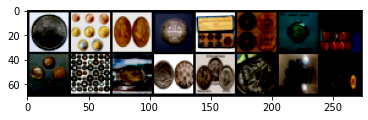


china_coins euro_coins peso_coins indian_coins china_coins china_coins peso_coins us_coins us_coins china_coins euro_coins china_coins us_coins indian_coins peso_coins china_coins


In [88]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# print(dataiter.next())
images, labels, paths = dataiter.next()

batch_size = 16

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [89]:
# CNN 모델 학습(모델 출처: https://learn.microsoft.com/ko-kr/windows/ai/windows-ml/tutorials/pytorch-train-model)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)

        self.pool = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)

        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)

        self.fc1 = nn.Linear(24*10*10, 6)

    def forward(self, input):
        x = F.relu(self.bn1(self.conv1(input)))      
        x = F.relu(self.bn2(self.conv2(x)))

        x = self.pool(x)          

        x = F.relu(self.bn4(self.conv4(x)))     
        x = F.relu(self.bn5(self.conv5(x)))

        #x = self.pool(x) 

        x = x.view(-1, 24*10*10)
        x = self.fc1(x)
        return x

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것

In [91]:
net = Net() # define the network
net = net.to(device) # send the network to the device

## Define a Loss function and optimizer

In [92]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(net.parameters(),lr=0.001, weight_decay=0.01) # optimizer

## Train the Network

In [93]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training') # epoch이 50일 때, training acc 46% 달성

# save the trained model
PATH = './net_pretrained.pth'
torch.save(net.state_dict(), PATH)

  0%|          | 0/77 [00:00<?, ?it/s]

[1,    50] loss: 0.045


  0%|          | 0/77 [00:00<?, ?it/s]

[2,    50] loss: 0.035


  0%|          | 0/77 [00:00<?, ?it/s]

[3,    50] loss: 0.027


  0%|          | 0/77 [00:00<?, ?it/s]

[4,    50] loss: 0.019


  0%|          | 0/77 [00:00<?, ?it/s]

[5,    50] loss: 0.012


  0%|          | 0/77 [00:00<?, ?it/s]

[6,    50] loss: 0.009


  0%|          | 0/77 [00:00<?, ?it/s]

[7,    50] loss: 0.005


  0%|          | 0/77 [00:00<?, ?it/s]

[8,    50] loss: 0.004


  0%|          | 0/77 [00:00<?, ?it/s]

[9,    50] loss: 0.002


  0%|          | 0/77 [00:00<?, ?it/s]

[10,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[11,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[12,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[13,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[14,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[15,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[16,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[17,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[18,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[19,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[20,    50] loss: 0.013


  0%|          | 0/77 [00:00<?, ?it/s]

[21,    50] loss: 0.014


  0%|          | 0/77 [00:00<?, ?it/s]

[22,    50] loss: 0.003


  0%|          | 0/77 [00:00<?, ?it/s]

[23,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[24,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[25,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[26,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[27,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[28,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[29,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[30,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[31,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[32,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[33,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[34,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[35,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[36,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[37,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[38,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[39,    50] loss: 0.019


  0%|          | 0/77 [00:00<?, ?it/s]

[40,    50] loss: 0.017


  0%|          | 0/77 [00:00<?, ?it/s]

[41,    50] loss: 0.005


  0%|          | 0/77 [00:00<?, ?it/s]

[42,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[43,    50] loss: 0.001


  0%|          | 0/77 [00:00<?, ?it/s]

[44,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[45,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[46,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[47,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[48,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[49,    50] loss: 0.000


  0%|          | 0/77 [00:00<?, ?it/s]

[50,    50] loss: 0.000
Finished Training


## Save the Network

In [94]:
# save the trained model
PATH = './net_pretrained.pth'
torch.save(net.state_dict(), PATH)

## Load the Network

In [95]:
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to(device)

## Calculate Training accuracy

In [96]:
train_test_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False) # make train_test loader

In [97]:
correct = 0
total = 0

image_id = []
predicted_label = []
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(train_test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(train_test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/1229 [00:00<?, ?it/s]

Accuracy of the network on the 1229 test images: 98 %


## Testing & Making a Submission File

In [98]:
from PIL import Image
import torch
from torch.utils.data import Dataset


class testDataset(Dataset):
    def __init__(self, data_dir, transform):
        # path to images
        path2data = os.path.join(data_dir)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # set transformations
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        image_name = self.full_filenames[idx]
        return image, image_name

In [99]:
test_data = testDataset('coins_images/TEST/',image_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False) # ALWAYS SET SHUFFLE FALSE

In [100]:
image_id = []
predicted_label = []
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(test_loader,0)):
        images, paths = data
        images = images.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        path = os.path.basename(paths[0])
        image_id.append(path)
        predicted_label.append(predicted.item())

  0%|          | 0/120 [00:00<?, ?it/s]

In [101]:
predicted_df = pd.DataFrame({'image_id': image_id, 'predicted_label': predicted_label})

In [102]:
predicted_df['predicted_label'] = predicted_df.predicted_label.astype(str)

In [103]:
predicted_df.to_csv('prediction_result.csv', index=False)